# Vietnamese HandWritting Classification

In [ ]:
This is the colab file for CoderSchool Hackathon with purpose to classify  the Vietnamese handwritting image OCR problem.

Things to improve for Hackathon:
- Copy files into train and test folder from sample folder 1 and 2.
- Handle labels with multiple json files.
- Resize image logics with multiple image sizes (maybe as following):
    + find min, max of height and width
    + resize to a fixed height you want
    + calculate the max width of all resized images
    + padding to all images to that max width
- Combine the logic of preprocessing of train set and test set together
- Convert them to tfdataset pipeline (note that it is challenging since OpenCV won't work with tensor)
- Rework/redesign new CRNN model to fit with your new processed images. 

In [ ]:
!pip install pandarallel
!pip install imutils
!pip install mahotas

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import json
import pandas as pd
from tqdm.notebook import tqdm
# make sure we use tensorflow 2.0
import tensorflow as tf
print(tf.__version__)

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import imutils
import mahotas 



2.2.0


In [ ]:
# finding where we are so we dont need to type absolute path everytime
current_directory_path = pathlib.Path(".").absolute()
current_directory_path

PosixPath('/content')

In [ ]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
rm -rf data

In [ ]:
!mkdir data data/test data/train data/raw

In [ ]:
# path to our directory images

# our train and test folder (not used for now but used later when we want to save images after processing)
DATA_PATH = os.path.join(str(current_directory_path), "data")
TEST_FOLDER = os.path.join(DATA_PATH, "test")
TRAIN_FOLDER = os.path.join(DATA_PATH, "train")

# our raw folders
RAW_TEST_FOLDER = os.path.join(DATA_PATH, "raw")

In [ ]:
print(DATA_PATH)
print(TEST_FOLDER)
print(TRAIN_FOLDER)

/content/data
/content/data/test
/content/data/train


In [ ]:
DATA_SAMPLE_1_FOLDER =  os.path.join(RAW_TEST_FOLDER,'0825_DataSamples 1')
DATA_SAMPLE_2_FOLDER =  os.path.join(RAW_TEST_FOLDER,'0916_Data Samples 2')
print(DATA_SAMPLE_1_FOLDER)
DATA_SAMPLE_1_FOLDER_ZIP = '0825_DataSamples\ 1.zip'
DATA_SAMPLE_2_FOLDER_ZIP = '0916_Data\ Samples\ 2.zip'

/content/data/raw/0825_DataSamples 1


In [ ]:
# we working on localhost or VM Cloud for now so no need this code section
from google.colab.patches import cv2_imshow #only in Colab because using cv2.imshow is not allowed in Colab
from google.colab import drive
drive.mount('/content/gdrive')
DATA_SAMPLE_1_FOLDER_ZIP = '/content/gdrive/My\ Drive/FTMLE\ -\ Tonga/Week_10/Hackathon/0825_DataSamples\ 1.zip'
DATA_SAMPLE_2_FOLDER_ZIP = '/content/gdrive/My\ Drive/FTMLE\ -\ Tonga/Week_10/Hackathon/0916_Data\ Samples\ 2.zip'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%%capture
!unzip $DATA_SAMPLE_1_FOLDER_ZIP -d $RAW_TEST_FOLDER
!unzip $DATA_SAMPLE_2_FOLDER_ZIP -d $RAW_TEST_FOLDER

In [ ]:
# checking if GPU is available 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # RIP Training time
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Reading images and organise folders

In [ ]:
col_names = ['name','label','path']
handwritting_df = pd.DataFrame(columns = col_names)
for path in [DATA_SAMPLE_1_FOLDER,DATA_SAMPLE_2_FOLDER]:
   path = pathlib.Path(path)
   label_path = os.path.join(path,'labels.json')
   with open(label_path,'r') as f:
      data = json.load(f)
   df = pd.DataFrame(data.items(),columns=col_names[:2])
   df['path'] = df['name'].apply(lambda x: os.path.join(path,x))  
   handwritting_df = pd.concat([handwritting_df,df])
print(handwritting_df.shape)
handwritting_df.sample(5)   


(1838, 3)


,name,label,path
1402,1402_samples.png,"06 Trần Quang Khải, Phường Phú Hội, Thành phố ...",/content/data/raw/0916_Data Samples 2/1402_sam...
282,0282_samples.png,"Số 438, Nguyễn Huệ, Phường Ninh Phong, Thành p...",/content/data/raw/0916_Data Samples 2/0282_sam...
396,0396_samples.png,"Số 6A, phố Trần Quốc Toản, phường Hàng Bài, Qu...",/content/data/raw/0916_Data Samples 2/0396_sam...
1061,1061_samples.png,"Số 7, ngõ 1/178 phố Thái Hà, Phường Trung Liệt...",/content/data/raw/0916_Data Samples 2/1061_sam...
92,0092_samples.png,"28/137, KP 3, Phường Tân Mai, Thành Phố Biên H...",/content/data/raw/0916_Data Samples 2/0092_sam...


In [ ]:
unique_characters = handwritting_df['label'].parallel_apply(lambda x: set(x))
char_list = set()
for item in unique_characters:
  char_list.update(item)
char_list = sorted(char_list)
print(len(char_list))
''.join(char_list)


140


" #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"

In [ ]:
# Constants (we choose this number as we later discover that the output of our CNN is (1,9,512) from out input)
TIME_STEPS = 239

In [ ]:
# find the maximum label length
label_lens= handwritting_df['label'].str.len()
max_label_len = max(label_lens)
print(max_label_len)


69


In [ ]:
# convert the words to array of indexs based on the char_list
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst

In [ ]:
# testing our encode function (text to number)
encode_to_labels("mỗi ngày một niềm vui") 

[56,
 121,
 53,
 0,
 57,
 51,
 73,
 68,
 0,
 56,
 122,
 63,
 0,
 57,
 53,
 110,
 56,
 0,
 65,
 64,
 53]

In [ ]:
# all possible image paths for training
raw_all_image_paths = handwritting_df['path']

In [ ]:
sample = raw_all_image_paths.sample(5)
print(sample)
for path in sample:
  print(cv2.imread(path).shape)

925     /content/data/raw/0916_Data Samples 2/0925_sam...
1414    /content/data/raw/0916_Data Samples 2/1414_sam...
1804    /content/data/raw/0916_Data Samples 2/1804_sam...
438     /content/data/raw/0916_Data Samples 2/0438_sam...
1229    /content/data/raw/0916_Data Samples 2/1229_sam...
Name: path, dtype: object
(102, 1854, 3)
(103, 1854, 3)
(102, 1851, 3)
(102, 1855, 3)
(102, 1853, 3)


In [ ]:
# %%time
# for image_path in all_image_paths:
#     img = cv2.imread(image_path)
#     (height, width, _) = img.shape
#     heights.append(height)
#     widths.append(width)

In [ ]:
%%time
df_shape = raw_all_image_paths.parallel_apply(lambda x: cv2.imread(x).shape)
widths = df_shape.parallel_apply(lambda x: x[1])
heights = df_shape.parallel_apply(lambda x: x[0])

CPU times: user 39 ms, sys: 118 ms, total: 157 ms
Wall time: 6.93 s


In [ ]:
min_height = min(heights)
max_height = max(heights)
min_width = min(widths)
max_width = max(widths)

print(min_height)
print(max_height)
print(min_width)
print(max_width)

94
376
955
2694


The result is (24, 24, 72, 72) for this dataset so it is definitely telling us 
that we don't need to resize the image at all. 
But imagine if the result is (a,b,c,d). Then we should resize all images to the height of a or b
Then padding horizontally following the new max width of resized images

In this case, our images got the same size so no need to do anything at all

In [ ]:
# this information is useful for making decision for padding and resizing
(min_height, max_height, min_width, max_width)

(94, 376, 955, 2694)

In [ ]:
# being a good Data Scientist, we need to have train set and test set
from sklearn.model_selection import train_test_split
test_size = 0.2
df_train, df_test = train_test_split(handwritting_df, test_size=test_size, random_state=42)

In [ ]:
df_train.shape

(1470, 3)

## Preprocessing

In [ ]:
def resizeByHeightImage(img,height):
    img = imutils.resize(img,height=height)
    return img

def resizeByWidthImage(img,width):
    img = imutils.resize(img,width=width)
    return img

def resizeImage(img,width,height):
    img = imutils.resize(img,width=width,height=height)
    return img

def gray_image(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def thresholding(img):
  blur = cv2.GaussianBlur(img, (5,5),0)
  gau= cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11, 4)
  return gau

def morphology(img):
  kernel_close=np.ones((2,2))
  mask=cv2.morphologyEx(img,cv2.MORPH_CLOSE,kernel_close)
  return mask

def deskew(image, width):
    (h, w) = image.shape[:2]

    # Find the image's center
    moments = cv2.moments(image)
    skew = moments['mu11'] / moments['mu02']
  
    # YOUR PART: Make the image stand up straight with warpAffine 
    # (double check the cheat sheet yesterday)
    M = np.float32([[1, skew, -0.5*w*skew],
                    [0, 1, 0]])
    image = cv2.warpAffine(image, M, (w, h))
    image = imutils.resize(image, width=width)
    return image

def center_extent(image, size):
    """ Process contours into training size.
        Make sure the digit image is in the middle of the image.
    """
    
    # RESIZE 
    (eW, eH) = size
    # if horizontal size is longer
    if image.shape[1] > image.shape[0]:
        # resize it to be eW
        image = imutils.resize(image, width=eW)
    elif image.shape[0] > image.shape[1]:
        # if vertical size is longer
        # resize it to be eH
        image = imutils.resize(image, height=eH)

    # CENTERIZE 
    # make a black canvas with train image size
    extent = np.zeros((eH, eW), dtype='uint8')
    
    # calculate the offsetX and offsetY of old image to new canvas
    offsetX = (eW - image.shape[1]) // 2
    offsetY = (eH - image.shape[0]) // 2

    # make sure the digit image is in the middle of the canvas
    extent[offsetY:offsetY + image.shape[0], offsetX:offsetX+image.shape[1]] = image
    
    # find the middle of digit
    CM = mahotas.center_of_mass(extent)
    (cY, cX) = np.round(CM).astype("int32")

    # find the displacement distance of that middle of the digit to the middle of the canvas
    (dX, dY) = ((size[0]//2) - cX, (size[1] // 2) - cY)

    # move the digit to be totally in the middle of the canvas
    M = np.float32([[1, 0, dX], 
                    [0, 1, dY]])
    extent = cv2.warpAffine(extent, M, size)
    
    return extent

def preprocessing(img):
  img = gray_image(img)
  img = thresholding(img)
  img = morphology(img)
  # img = deskew(img,max_width)
  img = center_extent(img,(max_width,max_height))
  return img

Khu 5A, Huyện Giao Thuỷ, Nam Định
Lê hoá, Huyện Tuyên Hoá, Quảng Bình
311 Điện Biên Phủ, Phường 04, Quận 3, TP Hồ Chí Minh
Cốc Pài, Thị trấn Cốc Pài, Huyện Xín Mần, Hà Giang
Xã Quỳnh Thọ, Huyện Quỳnh Lưu, Nghệ An


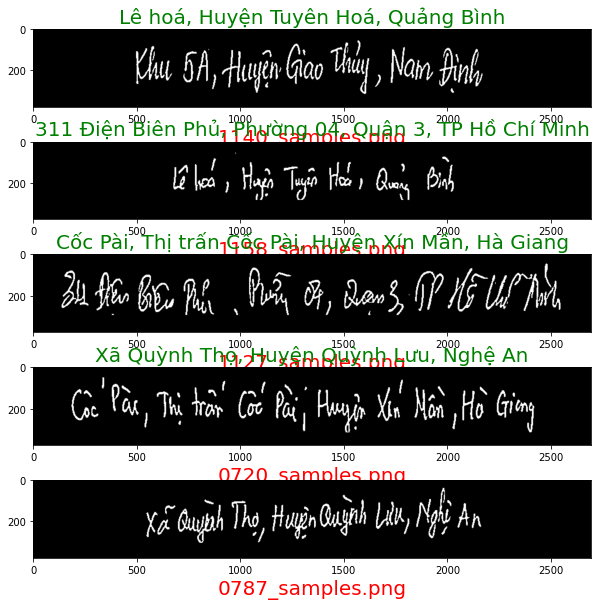

In [ ]:
NO_PREDICTS = 5
plt.figure(figsize=(10,10))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS, 1)
gs1.update(wspace=0.22, hspace=0.22)
path = handwritting_df.sample(10,random_state=102)
for n in range(NO_PREDICTS):
    row = path.iloc[n]
    label = row['label']
    print(label)
    name = row['name']
    img = cv2.imread(row['path'])
    img = imutils.resize(img,height=min_height)
    img = np.pad()

    img = preprocessing(img)
    plt.title(label, fontsize=20, color="green")
    plt.subplot(gs1[n])
    plt.xlabel(name, fontsize=20, color="red")
    plt.imshow(img, cmap="gray")

In [ ]:
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []


# BUILD THE PIPELINE FOR THE IMAGES, definitely this is super basic pipeline and can be improved
for index,row in tqdm(df_train.iterrows()):
    # print(f_name)
    # read input image and convert into gray scale image
    train_img_path = row['path']
    label = row['label']

    img = cv2.imread(train_img_path)
    img = cv2.resize(img,(min_width,min_height))
    img = preprocessing(img)
  
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    # split data into validation and training dataset as 10% and 90% respectively
    orig_txt.append(label)   
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label)) 


In [ ]:
for img in training_img[:5]:
  print(img.shape)

In [ ]:
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

for index,row in tqdm(df_test.iterrows()):
    # print(f_name)
    # read input image and convert into gray scale image
    test_img_path = row['path']
    label = row['label']
    img = cv2.imread(train_img_path)

    # resize to a fixed height you want
    img = cv2.imread(train_img_path)
    img = cv2.resize(img,(min_width,min_height))
    img = preprocessing(img)
      # calculate the max width of all resized images
    img = preprocessing(img)
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed test {} files".format(i))

In [ ]:
# this is the most controversial part when our max_label_len should be set different or slightly smaller than TIME_STEPS
# but let stick to the conventional/normal way: we should to be the same with our TIME_STEPS
max_label_len = TIME_STEPS 

In [ ]:
# pad each output label to maximum text length, remember we did that so that we keep training with rnn consistent?
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

## Model Building

In [ ]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=32 and width=128 
inputs = Input(shape=(min_height,min_width,1))
 
# convolution layer with kernel size (3,3)  #(24,72,64)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(12,36,64)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

#(12,36,128)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(6,18,128)
pool_2 = MaxPool2D(pool_size=(2, 1), strides=2)(conv_2)

#(6,18,256)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

# poolig layer with kernel size (2,2) to make the height/2  #(3,9,256)
pool_3 = MaxPool2D(pool_size=(2, 1))(conv_3)

batch_norm_3 = BatchNormalization()(pool_3)

#(3,9,256)
conv_4 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_3)
pool_4 = MaxPool2D(pool_size=(3, 1))(conv_4)
batch_norm_4 = BatchNormalization()(pool_4)

# Batch normalization layer #3,9,256)

#(3,9,512)
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
pool_5 = MaxPool2D(pool_size=(3, 1))(conv_5)

# # to remove the first dimension of one: (1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_5)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

NameError: ignored

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 94, 955, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 955, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 477, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 477, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 239, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 239, 256)      295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 239, 256)      0     

In [ ]:
### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath='checkpoint_weights.hdf5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=15,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 94, 955, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 94, 955, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 47, 477, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 477, 128) 73856       max_pooling2d[0][0]              
____________________________________________________________________________________________

In [ ]:
# notice I convert everything to numpy array here since model can fit either tensors and numpy array
# the reason why i stick with numpy array because it is simple to code and also because it is baseline solution
# I want to use openCV (can't run with tensors because it is CPU operations)
# And if I want to use tensors then i will make sure my image preprocessing functions uses tensor compatible operations

# ready our training data
training_img = np.array(training_img)

train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our test data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

## Model Training

 **Yann LeCun** said:
"Training with large minibatches is bad for your health.
 More importantly, it's bad for your test error.
 Friends dont let friends use minibatches larger than 32."

In [ ]:
# choose batchsize and epochs

batch_size = 32
epochs = 100

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 232.9061
Epoch 00001: val_loss improved from inf to 206.43094, saving model to checkpoint_weights.hdf5
46/46 [==============================] - 60s 1s/step - loss: 232.9061 - val_loss: 206.4309 - lr: 0.0010
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 202.7135
Epoch 00002: val_loss improved from 206.43094 to 204.82999, saving model to checkpoint_weights.hdf5
46/46 [==============================] - 50s 1s/step - loss: 202.7135 - val_loss: 204.8300 - lr: 0.0010
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 200.0779
Epoch 00003: val_loss improved from 204.82999 to 201.13545, saving model to checkpoint_weights.hdf5
46/46 [==============================] - 50s 1s/step - loss: 200.0779 - val_loss: 201.1355 - lr: 0.0010
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 196.4621

KeyboardInterrupt: ignored

In [ ]:
# save our model
model.save('lastest_model.h5')

## Decode and Prediction

In [ ]:
# load the saved best model weights
act_model.load_weights('lastest_model.h5')

In [ ]:
# predict outputs on validation images
NO_PREDICTS = 200
OFFSET=0
prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])
#prediction = act_model.predict(valid_img)

In [ ]:
valid_img.shape

(1991, 24, 72, 1)

In [ ]:
# NO_PREDICTS image results
# 9 timesteps
# 32 chars + 1 blank
prediction.shape

(200, 9, 33)

In [ ]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", valid_orig_txt[i+OFFSET])
    print("predicted text = ", end = '')
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    print(pred)
    all_predictions.append(pred)
    i+=1

original_text  =  HS5H
predicted text = HS5H
original_text  =  DGNL
predicted text = DGNL
original_text  =  XKM7
predicted text = XKM7
original_text  =  BET4
predicted text = BET4
original_text  =  JFWW
predicted text = JFWW
original_text  =  BP98
predicted text = BP98
original_text  =  9QK4
predicted text = 9QK4
original_text  =  WM2J
predicted text = WM2J
original_text  =  92WP
predicted text = 92WP
original_text  =  GM9C
predicted text = GM9C
original_text  =  5WZJ
predicted text = 5WZJ
original_text  =  FDFG
predicted text = FDFG
original_text  =  6Y4X
predicted text = 6Y4X
original_text  =  LBU4
predicted text = LBU4
original_text  =  MRKC
predicted text = MRKC
original_text  =  AHLA
predicted text = AHLA
original_text  =  GL8U
predicted text = GL8U
original_text  =  2QP5
predicted text = 2QP5
original_text  =  H9SF
predicted text = H9SF
original_text  =  P74S
predicted text = P74S
original_text  =  W5AX
predicted text = W5AX
original_text  =  WC87
predicted text = WC87
original_t

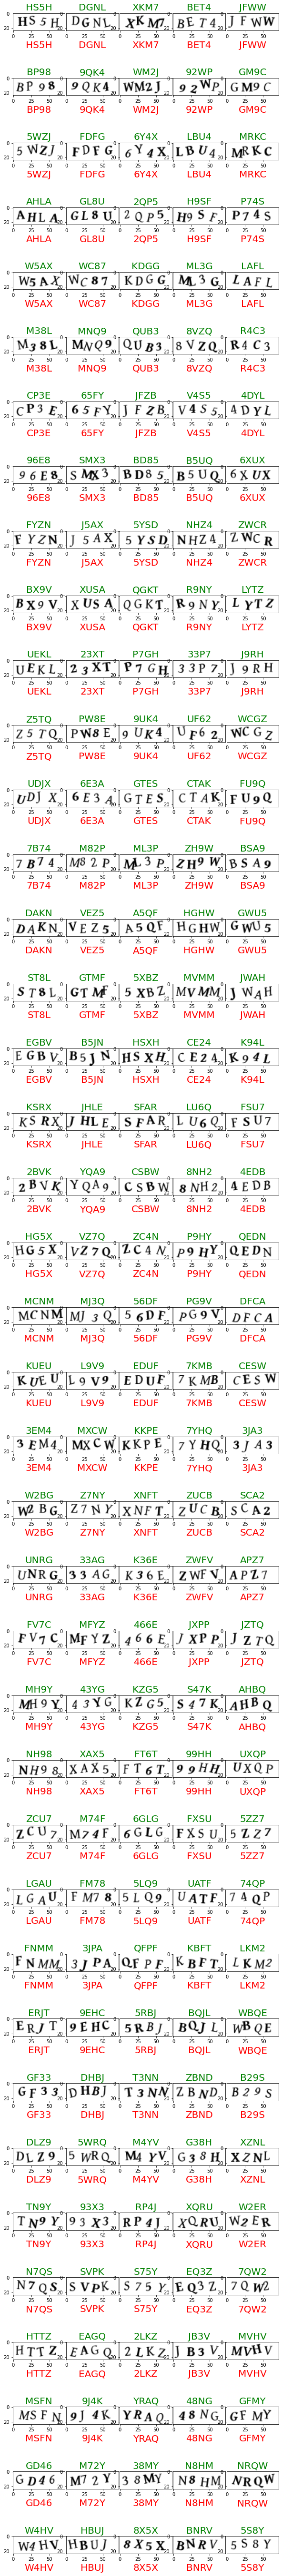

In [ ]:
#YOUR PART: WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,100))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS//5, 5)
gs1.update(wspace=0.025, hspace=0.025)
for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.title(valid_orig_txt[n+OFFSET], fontsize=20, color="green")
    plt.imshow(valid_img[n][:,:,0], cmap="gray")
    plt.xlabel(all_predictions[n+OFFSET], fontsize=20, color="red")


## Evaluation using CER, WER and SER

Tool to metrics calculation through data and label (string and string).
 * Calculation from Optical Character Recognition (OCR) metrics with editdistance.
This is borrowed from https://github.com/arthurflor23/handwritten-text-recognition/blob/master/src/data/evaluation.py

It is not needed to understand this function deeply, it only helps to calculate three evaluation metris:
- CER (Character Error Rate)
- WER (Word Error Rate)
- SER (Sequence Error Rate)

In [ ]:
import string
import unicodedata
import editdistance


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [ ]:
evaluate = ocr_metrics(predicts=all_predictions,
                                  ground_truth=valid_orig_txt,
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "Character Error Rate: {}".format(evaluate[0]),
    "Word Error Rate:      {}".format(evaluate[1]),
    "Sequence Error Rate:  {}".format(evaluate[2]),
])

This is a easy dataset so I got perfect score for absolutely the test set! Not even a challenge for CRNN power!

In [ ]:
print(e_corpus)

Metrics:
Character Error Rate: 0.0
Word Error Rate:      0.0
Sequence Error Rate:  0.0


In [ ]:
So what do we learn from here:
- CRNN + CTC is not that challenging, just want sure we follow above process step by step
- Keep our height and width is a power of 2 or at least even number is making our time much 
easier to divide by half (it is not really important, since it is related to design your model and preprocessing)
- The number bi LSTM paramater is larger the number of timestep since our biLSTM /2 will be at least the size of hidden node for each single LSTM.
- The max label length should be the same to the number of time steps, but some people report if they set it to be slightly lower than time step, it helps. 
But you should stick with the basics!
- The data is super clean and same image dimension. So for other datasets, maybe a bit of noise cleaning and binarization may help!
